In [115]:
import os
import sys
import torch
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
from torchvision import transforms

sys.path.append(os.path.abspath(os.path.join("..")))

In [116]:
from src.models.autoencoder import AELitModule

data_dir = "../data/FDP/"
sample_size = 12
ICSD_codes = os.listdir(data_dir)
chosen_codes = np.random.choice(ICSD_codes, sample_size)

In [117]:
run = "logs/train/runs/2023-08-09_02-52-26"

epochs = [0, 9, 19, 29, 39, 49, 59, 69, 79, 89, 99]
epochs_fakes = []

transform = transforms.ToTensor()
structures = torch.stack(
    [
        transform(
            np.load(
                os.path.join(data_dir, ICSD_code, ICSD_code + "_structure.npy")
            ).astype(np.float32)
        )
        for ICSD_code in chosen_codes
    ]
)
patterns = torch.stack(
    [
        transform(
            np.clip(
                np.load(os.path.join(data_dir, ICSD_code, ICSD_code + "_+0+0+0.npy")),
                0,
                1,
            ).astype(np.float32)
        )
        for ICSD_code in chosen_codes
    ]
)

for epoch in epochs:
    epoch = str(epoch).zfill(3)
    litmodule = AELitModule.load_from_checkpoint(
        os.path.join(os.getcwd(), "..", run, "checkpoints", f"epoch_{epoch}.ckpt")
    )
    fakes = litmodule.model(structures.cuda())
    fakes = fakes.view(sample_size * 128, 128).detach().cpu().numpy()
    epochs_fakes.append(fakes)

structures = structures.view(sample_size * 128, 128).detach().cpu().numpy()
patterns = patterns.view(sample_size * 128, 128).detach().cpu().numpy()

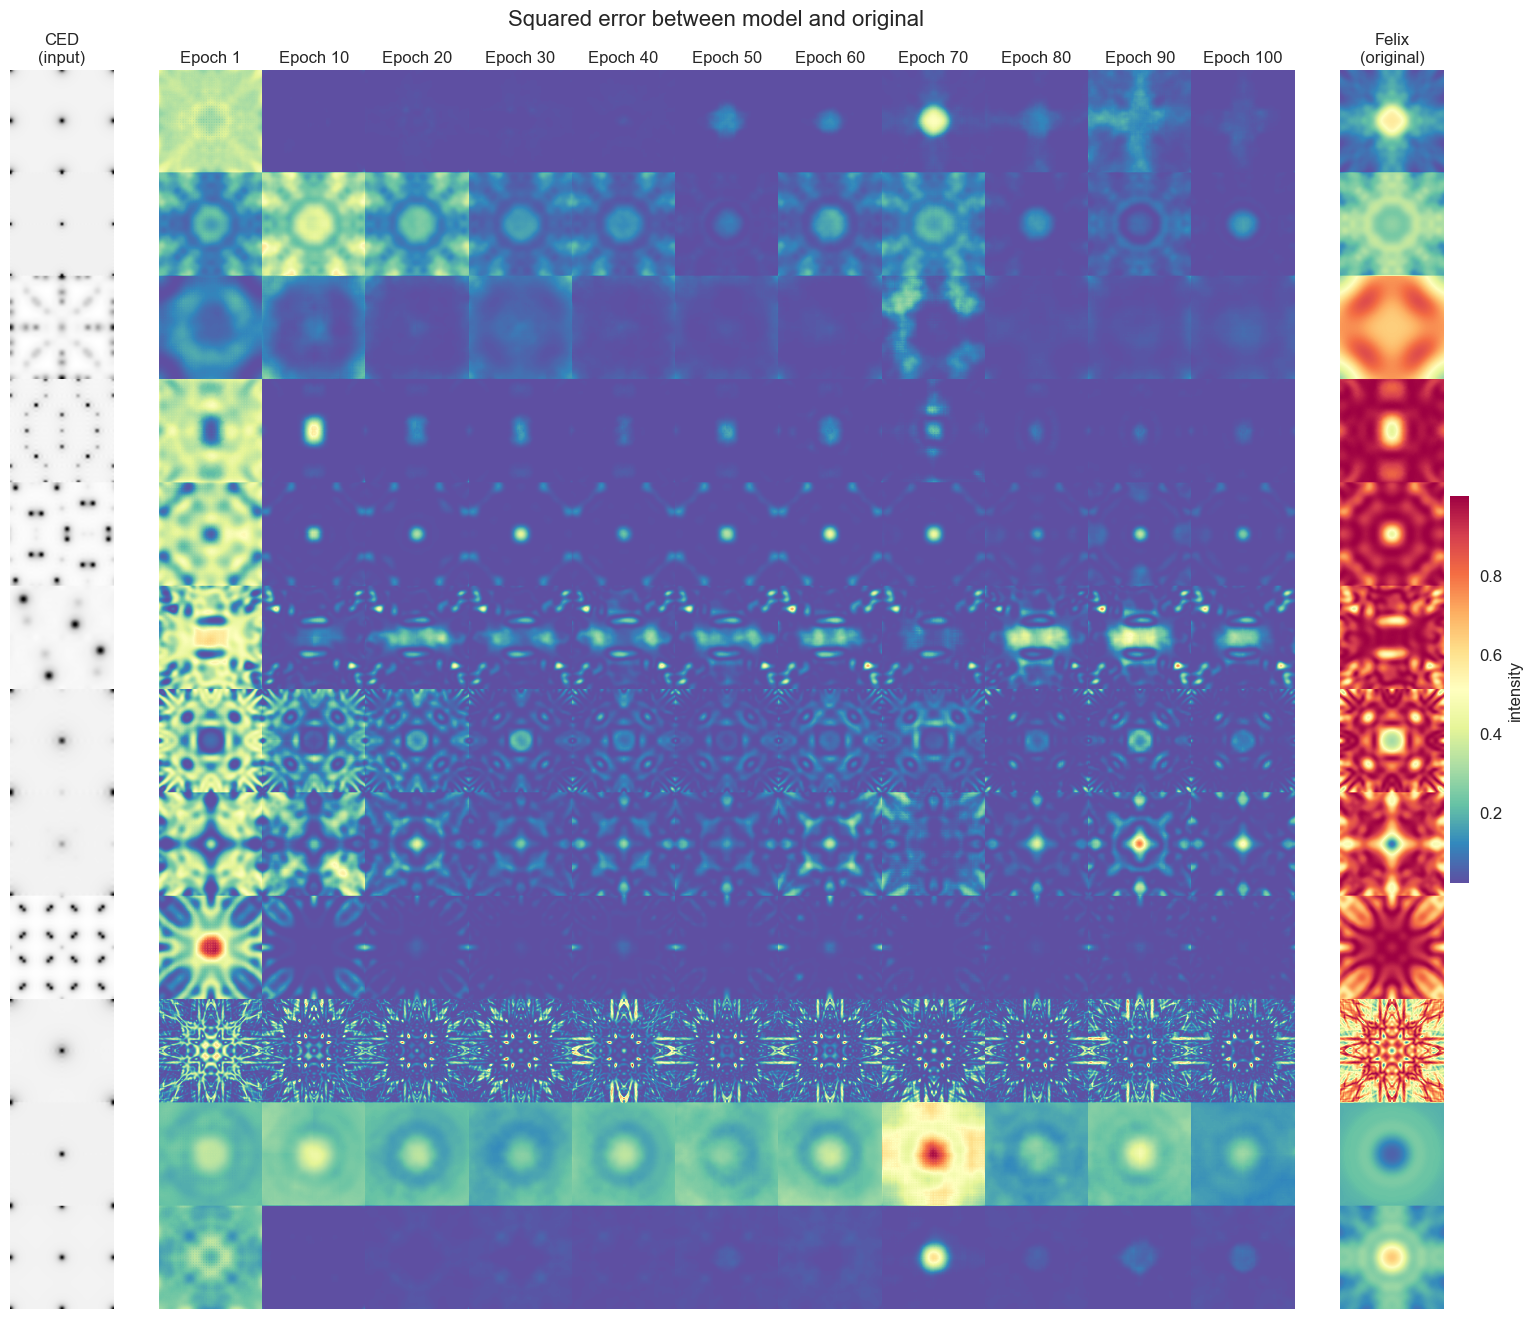

In [118]:
squared_difference = []
for i in range(len(epochs)):
    squared_difference.append((patterns - epochs_fakes[i])**2)

plt.style.use("seaborn-v0_8")
scale = 1.4
fig = plt.figure(figsize=(scale * (len(epochs) + 2.45), scale * sample_size))
gs0 =  gridspec.GridSpec(1, 3, wspace=0.1, width_ratios=[1, len(epochs), 1.25])
gs00 = gridspec.GridSpecFromSubplotSpec(1, len(epochs), wspace=0, width_ratios=[*[1]*len(epochs)],
                                        subplot_spec=gs0[1])
axs = [fig.add_subplot(gs00[0, i]) for i in range(len(epochs))]
axs.append(fig.add_subplot(gs0[2]))
axs.append(fig.add_subplot(gs0[0]))

for i, epoch in enumerate(epochs):
    im = axs[i].imshow(squared_difference[i], cmap="Spectral_r")
    axs[i].set_title(f"Epoch {str(epoch + 1)}")

im1 = axs[-2].imshow(1 - patterns, cmap="Spectral_r")
axs[-2].set_title("Felix\n(original)")
cbar = fig.colorbar(im1, ax=axs[-2], label="intensity")
cbar.ax.tick_params(labelsize=12)
cbar.ax.yaxis.label.set_size(12)

im0 = axs[-1].imshow(structures, cmap="Greys")
axs[-1].set_title("CED\n(input)")

fig.suptitle("Squared error between model and original", y=0.9, fontsize=16)

for ax in axs:
    ax.axis("off")

plt.show()

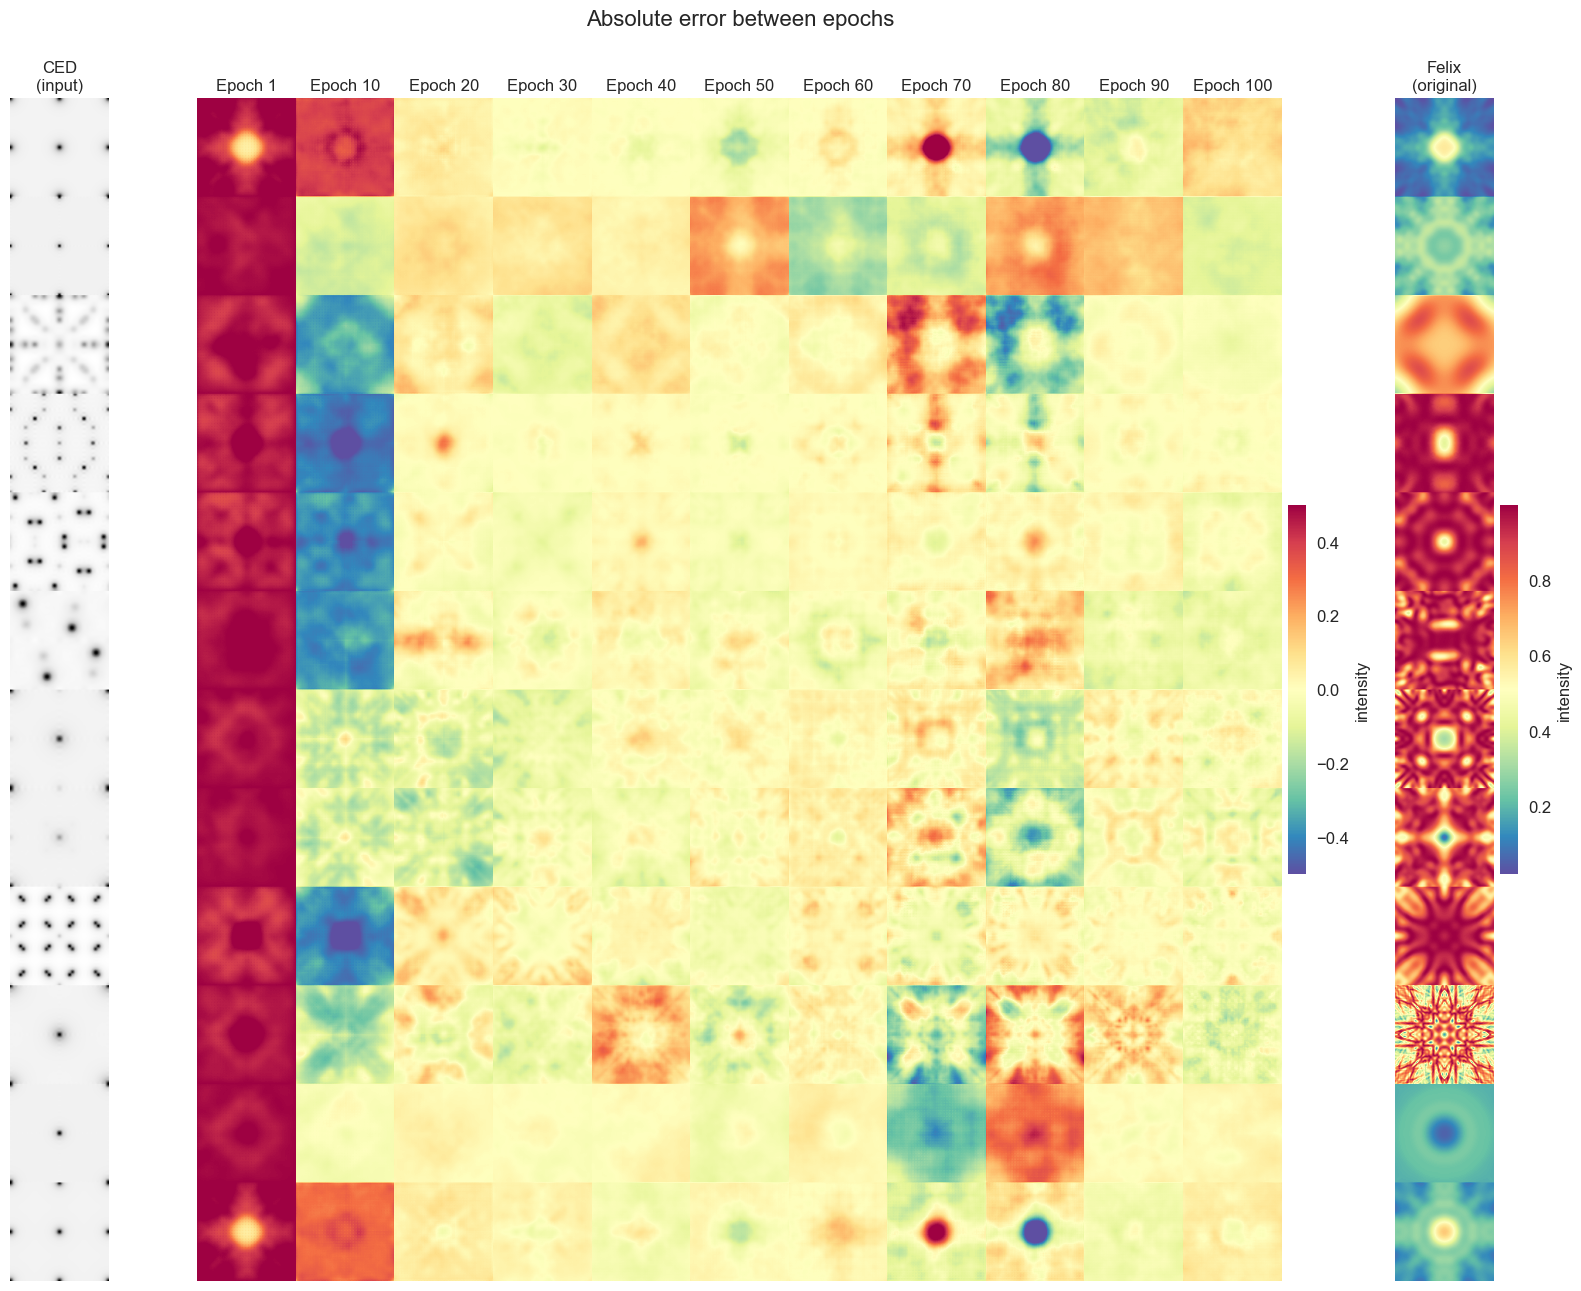

In [124]:
epoch_difference = [epochs_fakes[0]]
for i in range(1, len(epochs)):
    epoch_difference.append((epochs_fakes[i] - epochs_fakes[i-1]))

plt.style.use("seaborn-v0_8")
scale = 1.4
fig = plt.figure(figsize=(scale * (len(epochs) + 2.9), scale * sample_size))
gs0 =  gridspec.GridSpec(1, 3, wspace=0.2, width_ratios=[1, len(epochs)+0.25, 1.25])
gs00 = gridspec.GridSpecFromSubplotSpec(1, len(epochs), wspace=0, width_ratios=[*[1]*(len(epochs)-1), 1.25],
                                        subplot_spec=gs0[1])
axs = [fig.add_subplot(gs00[0, i]) for i in range(len(epochs))]
axs.append(fig.add_subplot(gs0[2]))
axs.append(fig.add_subplot(gs0[0]))

for i, epoch in enumerate(epochs):
    im = axs[i].imshow(epoch_difference[i], cmap="Spectral_r", vmin=-0.5, vmax=0.5)
    axs[i].set_title(f"Epoch {str(epoch + 1)}")
    if i==len(epochs)-1:
        cbar1 = fig.colorbar(im, ax=axs[i], label="intensity")
        cbar1.ax.tick_params(labelsize=12)
        cbar1.ax.yaxis.label.set_size(12)

im1 = axs[-2].imshow(1 - patterns, cmap="Spectral_r")
axs[-2].set_title("Felix\n(original)")
cbar2 = fig.colorbar(im1, ax=axs[-2], label="intensity")
cbar2.ax.tick_params(labelsize=12)
cbar2.ax.yaxis.label.set_size(12)

im0 = axs[-1].imshow(structures, cmap="Greys")
axs[-1].set_title("CED\n(input)")

fig.suptitle("Absolute error between epochs", y=0.9, fontsize=16)

for ax in axs:
    ax.axis("off")

plt.show()